## Objectif de l'EDA
-   **Comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation**.

## Checklist 
### Analyse de la forme :
-   **Identification de la target**: `cut` (variable catégorielle ordonnée ): fair < good < very good < premiumn < ideal
-   **Nombre de lignes et de colonnes**: `53940 lignes, 10 colonnes`
-   **Types de variables**: Quantitatives(`carat`, `table`, `depth`, `price`, `x`, `y`, `z`), Qualitatives(`color`, `clarity`, `cut`)
-   **Identification des valeurs manquantes**: RAS
### Analyse du fond :
-   **Visualisation de la target**: Domination de la classe `ideal (39%)`, les classes `good(9%)` et `fair(3%)` sont moins représentées.
-   **Compréhension des différentes variables**: ok
-   **Visualisation des variables qualitatives**: la `couleur J(5%)` est sous représentée, les niveaux de clarté `VVS2(9%)`, `VVS1(7%)`, `IF(3%)`, `I1(1%)` sont sous représentés.  
-   **Visualisation des variables quantitatives**: Presque toutes les variables présentent une asymétrie(la distribution est concentrée à gauche), cependant les variables sont plus centrées. 
-   **Visualisation des relations quali/target**: Pour chaque variable catégorielle, le nombre d'occurences de chaque classe varie probablement d'une manière significative en fonction des valeurs de la target , peut etre un `test de chi2` pourra apporter plus de précision.
-   **Visualisation des relations quanti/target**: Les moyennes de chaque sous groupe diffèrent probablement d'une manière significative d'une valeur de la target à une autre, un `test d'ANOVA` est envisagé. 
-   **Visualisation des relations quanti/quanti**: Les variables carat, price, x, y et z **sont correlées(corrélations fortes)**, un `PCA` sera fortement envisageable.
-   **Visualisation des relations quali/quali**: Les couleurs des diamants influencent à probablement les **niveaux de clarté SI1, SI2, VS1, VS2**. Hypothèse a tester? Pas nécessaire compte tenu du fait que certains modèles peuvent comprendre ces relations.
-   **Visualisation des relations quanti/quali**: Rien de flagrant entre quanti et color les modèles vont détecter avec plus de précisions les relations entre ces variables. Mais pour la relation quanti/clarté, le meme niveau de clarté (I1) apparait plus décalé à droite; ce qui veut probablement dire que la variable clarity est un bon segmentant des variables quantitatives, elle semble capturer une information latente de qualité. Un test d'ANOVA pourrait nous apporter plus de certitude mais ce n'est pas obligatoire car notre objectif est de prédire la qualité de la coupe.
-   **Identification des outliers**: Beaucoup de outliers de manière générale. Mais certains outliers`(x=0, y=0, z=0, z > 30, y > 30)` n'ont aucun sens d'un point de vue métier donc leur suppression est envisageable. Pour les autres outliers qui semblent plausibles, nous verrons comment les traiter après un éventuel PCA.

### Test statistiques:
-   **Relation Quanti/target (Test d'ANOVA)**:
    - H0: "les moyennes de la variable quantitative sont sont égales entre les groupes définis par cut."
    - **Résultats**: **H0 rejetée pour toutes les variables quantitatives.**
-   **Relation Quali/target (Test de chi2)**:
    - H0: "la répartition des valeurs de la variable qualitative(ex clarity) est identique pour toutes les qualités de coupe."
    - **Résultats**: **H0 rejétée pour toutes les variables qualitatives.**

In [149]:
import sys
import os
import yaml

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# fonction pour charger les configurations de config.yaml
def load_config(config_path='C:/Users/DELL/Documents/VEMV/pycaret/work/Diamond_cut_prediction/config/config.yaml'):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# chargement des configurations
config = load_config()

# Ajout du dossier 'src' au chemin Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

# importation du module
from data_loader import load_raw_data

# chargement du dataset
path = config['data']['raw_path']
data = load_raw_data(path)
data.head()


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Analyse de la forme

In [150]:
# suppresion de la colonne des index (inutile)
df = data.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [151]:
# dimensions du datset
df.shape

(53940, 10)

In [152]:
# types de variables
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [153]:
# identification des valeurs manquantes
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### Analyse du fond

In [154]:
# customisation de l'ordre des variables catégorielles étant donné qu'elles sont toutes ordonnées
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

df['cut'] = pd.Categorical(df['cut'], categories=cut_order, ordered=True)
df['clarity'] = pd.Categorical(df['clarity'], categories=clarity_order, ordered=True)
df['color'] = pd.Categorical(df['color'], categories=color_order, ordered=True)

In [155]:
df.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

<Axes: xlabel='cut', ylabel='count'>

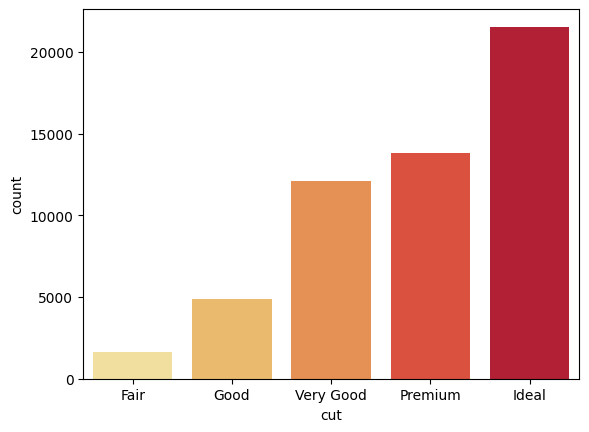

In [156]:
# visualisation de la target
plt.figure()
sns.countplot(data=df, x='cut', hue='cut', palette='YlOrRd', legend=False)

In [157]:
doublons = df.duplicated()
doublons.value_counts()

False    53794
True       146
Name: count, dtype: int64

In [158]:
# Pourcentages des classes
df.cut.value_counts(normalize=True)

cut
Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: proportion, dtype: float64

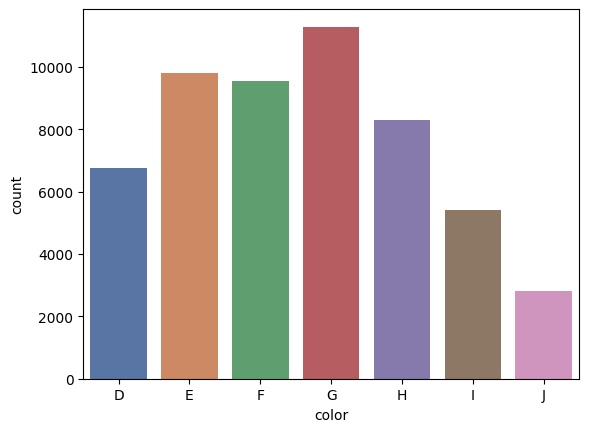

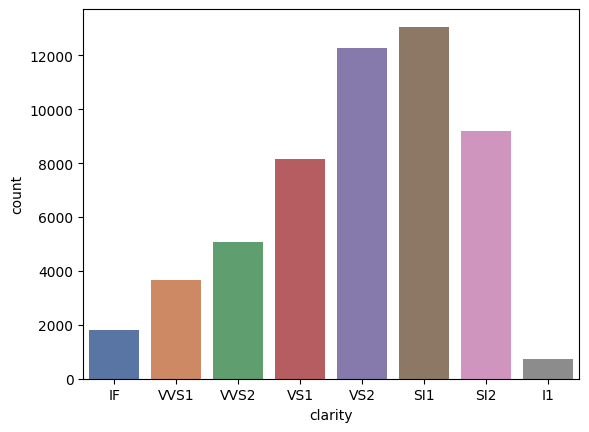

In [159]:
# visulisation des variables qualitatives
for col in df.select_dtypes('category').drop('cut', axis=1).columns:
    plt.figure()
    sns.countplot(data=df, x=df[col], hue =df[col], palette='deep', legend=False)

In [160]:
# pourcentage des valeurs
for col in df.select_dtypes('category').drop('cut', axis=1).columns:
    print(df[col].value_counts(normalize=True))

color
G    0.209344
E    0.181628
F    0.176900
H    0.153949
D    0.125603
I    0.100519
J    0.052058
Name: proportion, dtype: float64
clarity
SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: proportion, dtype: float64


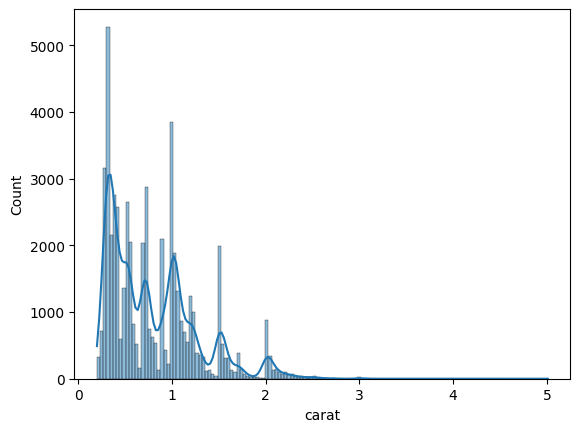

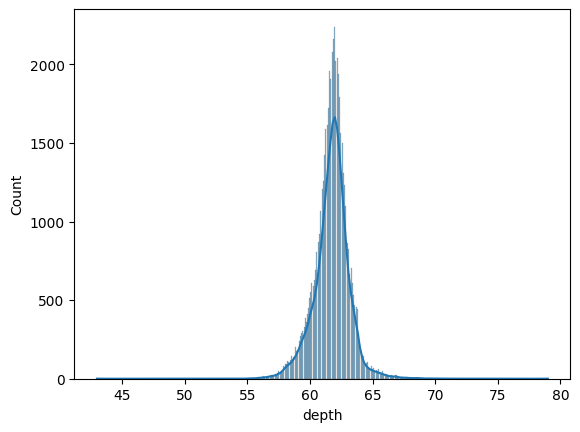

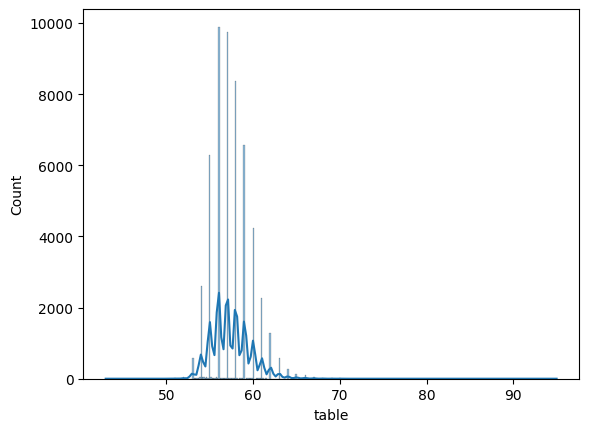

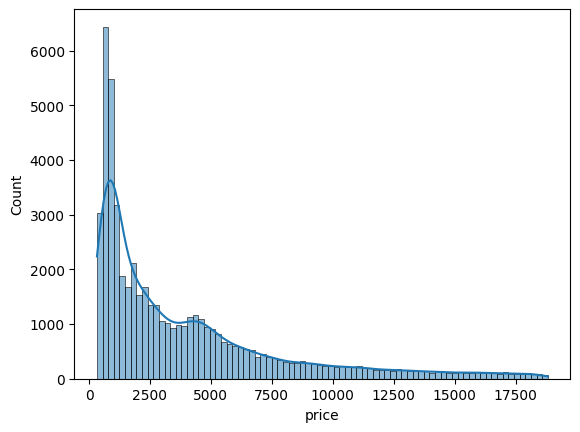

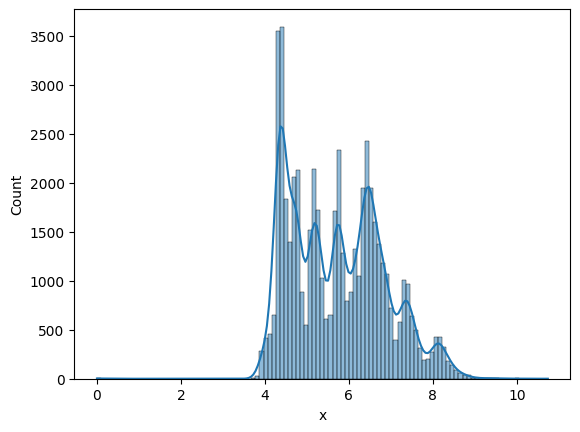

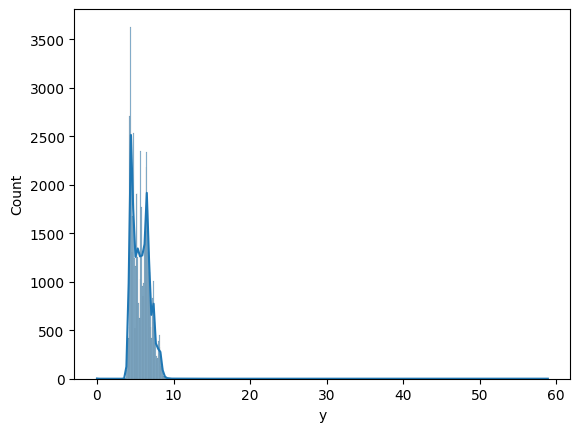

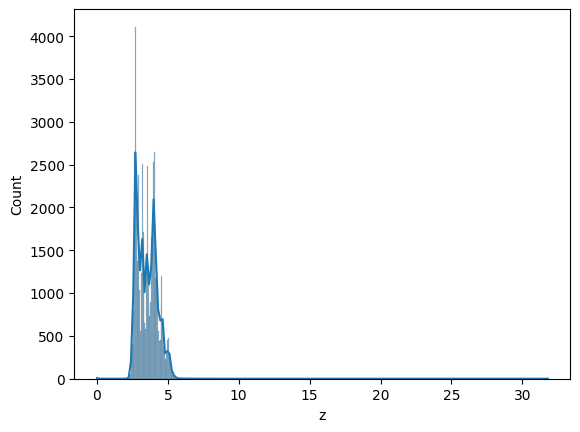

In [161]:
# Visualisation des variables quantitatives
for c in df.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.histplot(df[c], kde=True)

In [162]:
# Relations quali/target
pd.crosstab(df['cut'], df['color'])

color,D,E,F,G,H,I,J
cut,,,,,,,
Fair,163,224,312,314,303,175,119
Good,662,933,909,871,702,522,307
Very Good,1513,2400,2164,2299,1824,1204,678
Premium,1603,2337,2331,2924,2360,1428,808
Ideal,2834,3903,3826,4884,3115,2093,896


In [163]:
pd.crosstab(df['cut'], df['clarity'])

clarity,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1
cut,,,,,,,,
Fair,9,17,69,170,261,408,466,210
Good,71,186,286,648,978,1560,1081,96
Very Good,268,789,1235,1775,2591,3240,2100,84
Premium,230,616,870,1989,3357,3575,2949,205
Ideal,1212,2047,2606,3589,5071,4282,2598,146


In [164]:
df['cut'].unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Fair' < 'Good' < 'Very Good' < 'Premium' < 'Ideal']

In [165]:
# Mini datasets
fair = df[df['cut'] == 'Fair']
good = df[df['cut'] == 'Good']
very_good = df[df['cut'] == 'Very Good']
premium = df[df['cut'] == 'Premium']
ideal = df[df['cut'] == 'Ideal']

In [166]:
ideal

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
11,0.23,Ideal,J,VS1,62.8,56.0,340,3.93,3.90,2.46
13,0.31,Ideal,J,SI2,62.2,54.0,344,4.35,4.37,2.71
16,0.30,Ideal,I,SI2,62.0,54.0,348,4.31,4.34,2.68
39,0.33,Ideal,I,SI2,61.8,55.0,403,4.49,4.51,2.78
...,...,...,...,...,...,...,...,...,...,...
53925,0.79,Ideal,I,SI1,61.6,56.0,2756,5.95,5.97,3.67
53926,0.71,Ideal,E,SI1,61.9,56.0,2756,5.71,5.73,3.54
53929,0.71,Ideal,G,VS1,61.4,56.0,2756,5.76,5.73,3.53
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50


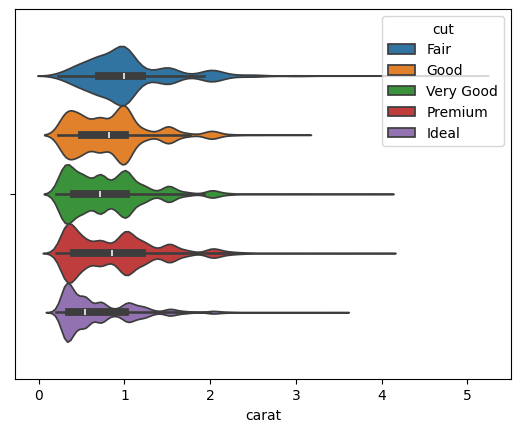

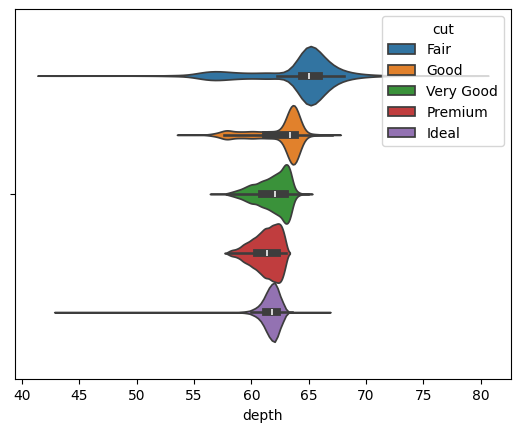

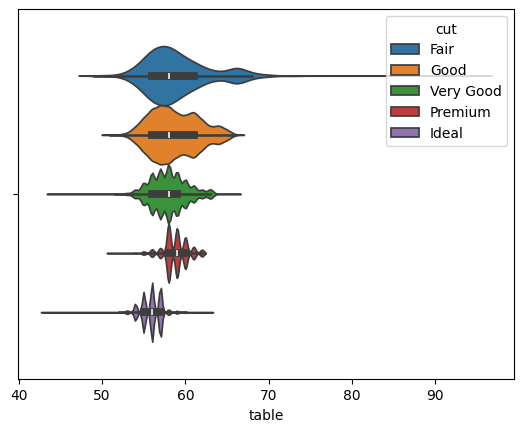

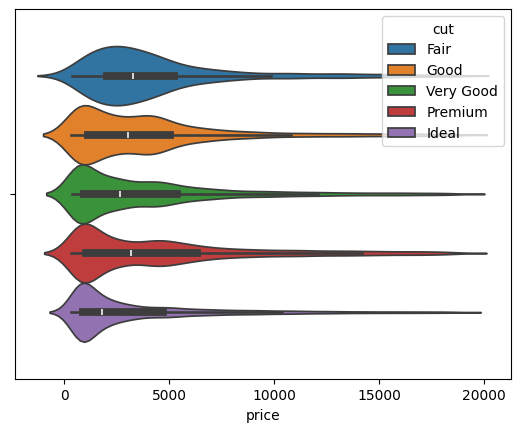

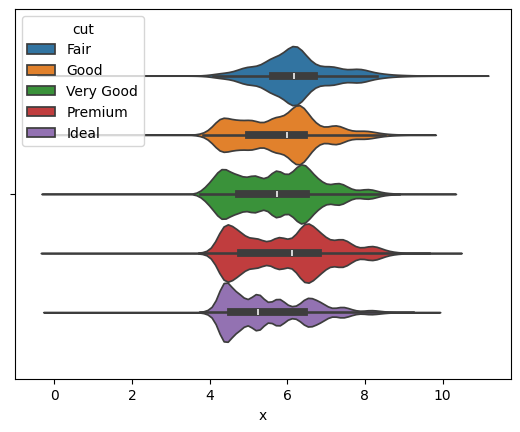

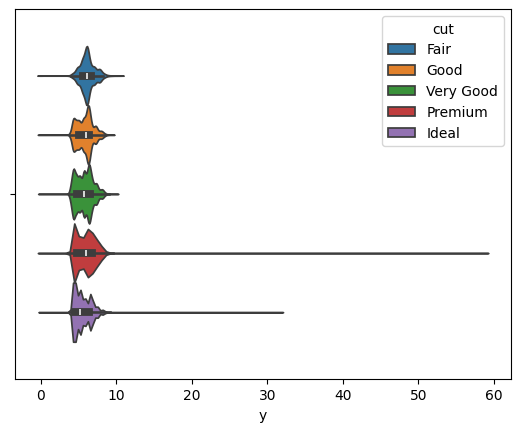

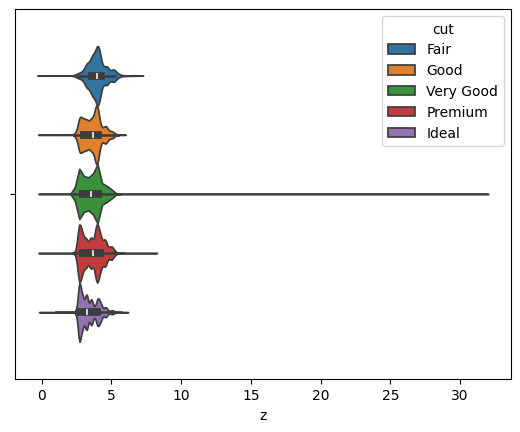

In [167]:
# Relations quanti/target
for col in df.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.violinplot(data=df, x=df[col], hue='cut')
    

<Axes: >

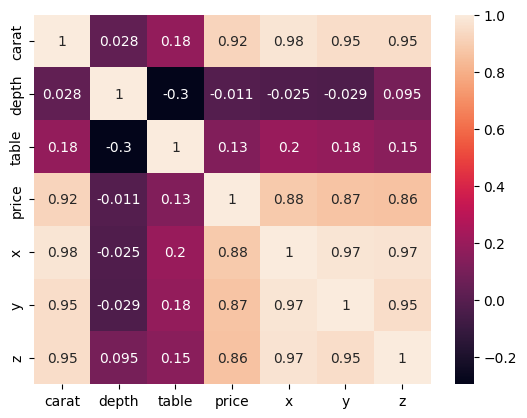

In [168]:
# Relations quanti/quanti
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True)

<Axes: xlabel='clarity', ylabel='color'>

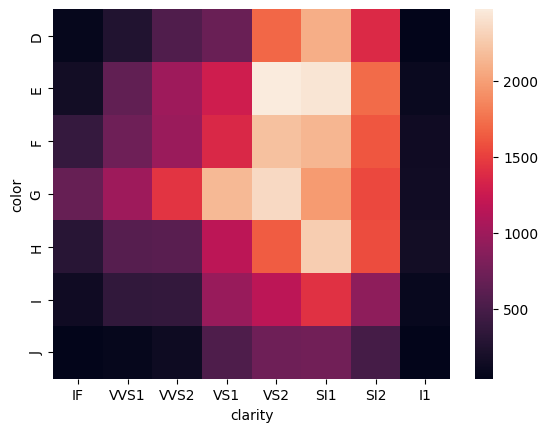

In [169]:
# Relation quali/quali (color/clarity)
sns.heatmap(pd.crosstab(df['color'], df['clarity']))

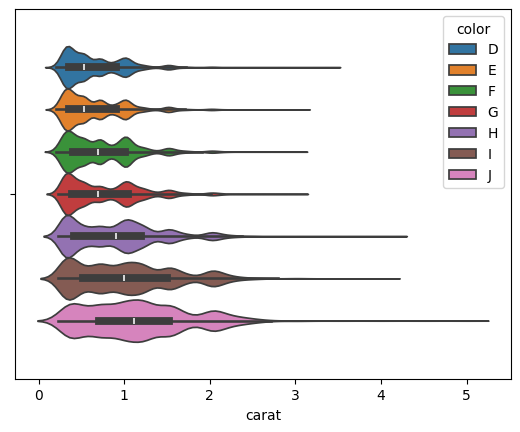

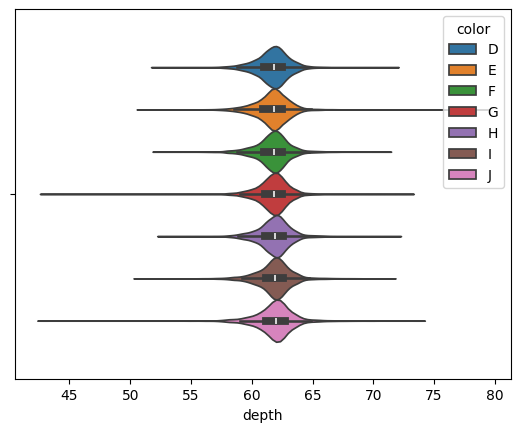

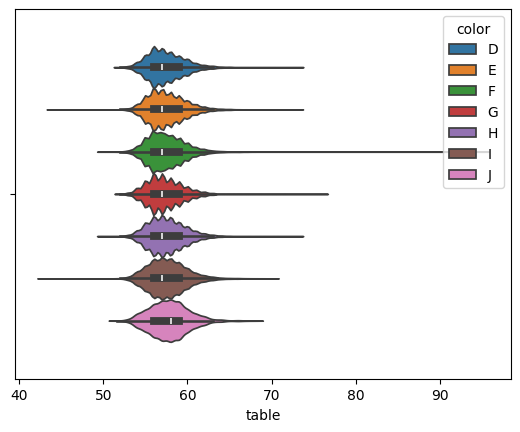

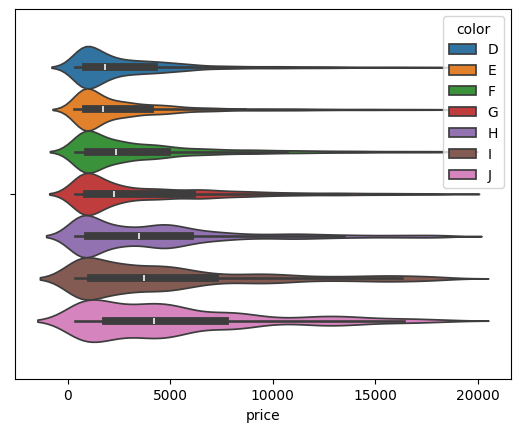

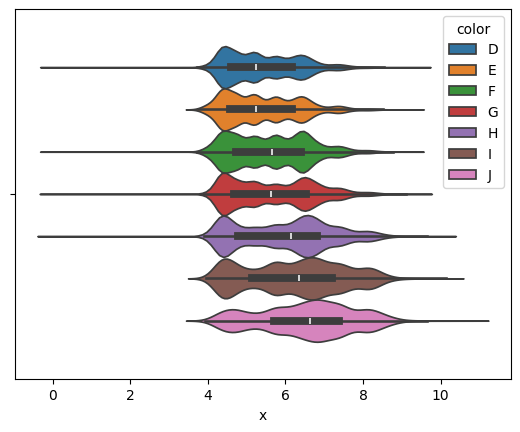

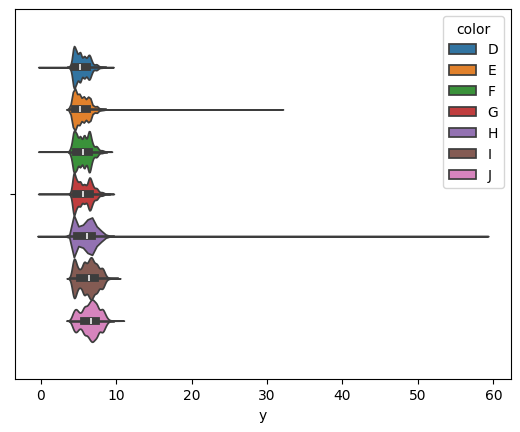

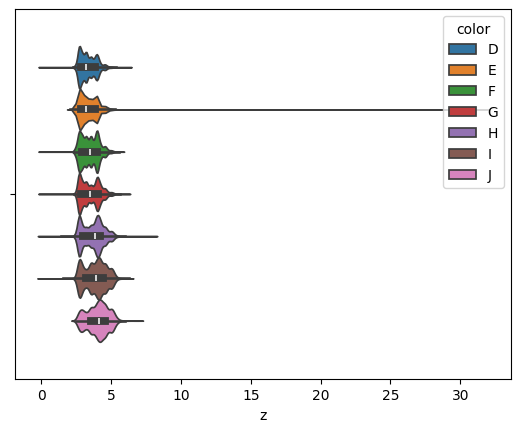

In [170]:
# Relation quanti/color
for i in df.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.violinplot(data=df, x=df[i], hue='color')

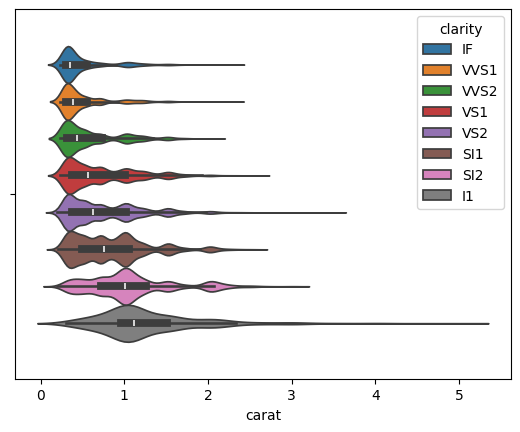

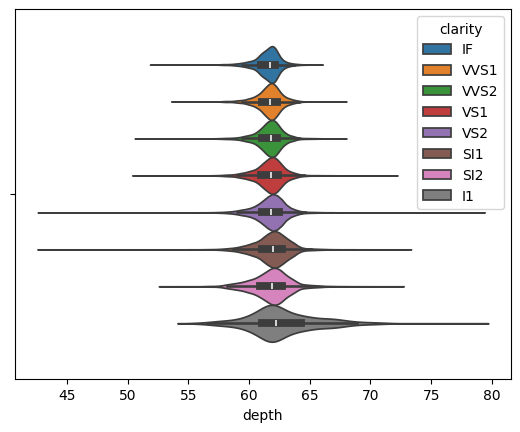

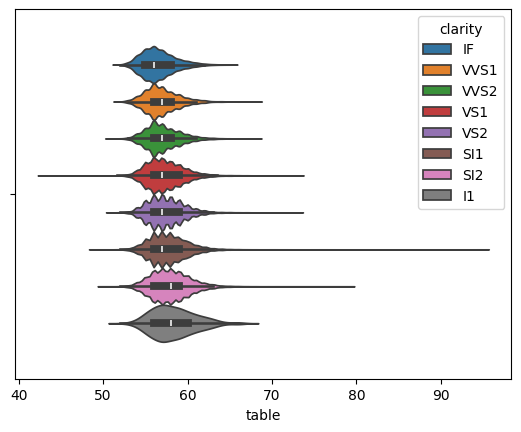

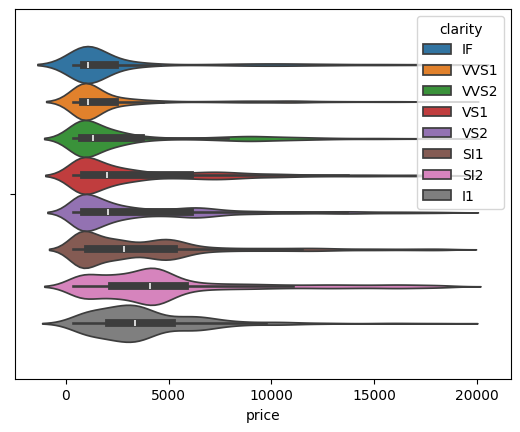

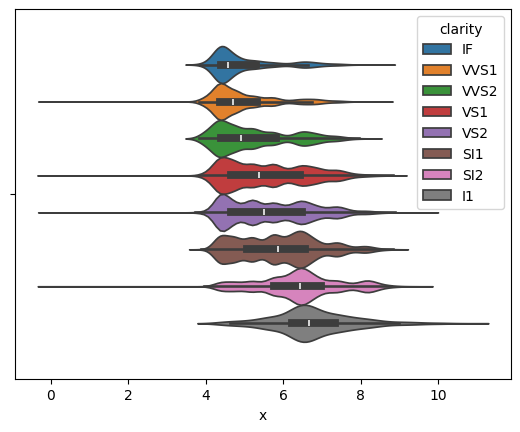

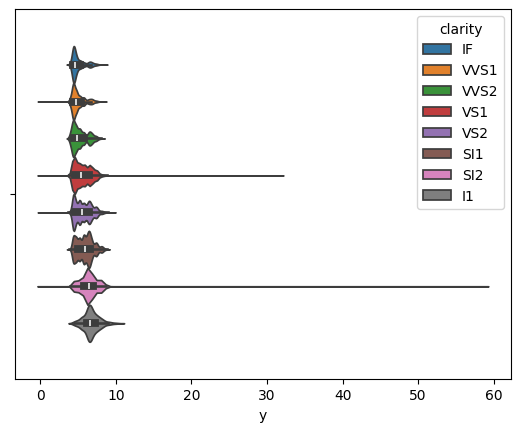

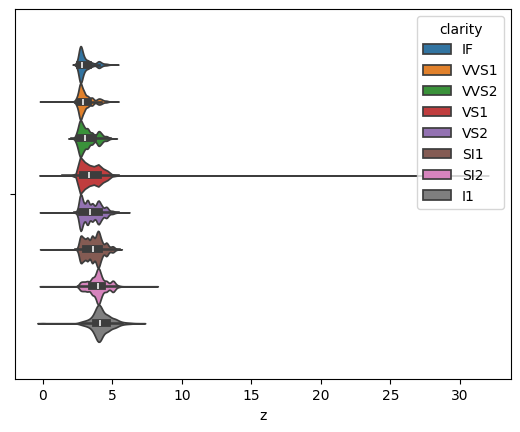

In [171]:
# Relation quanti/clarity
for i in df.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.violinplot(data=df, x=df[i], hue='clarity')

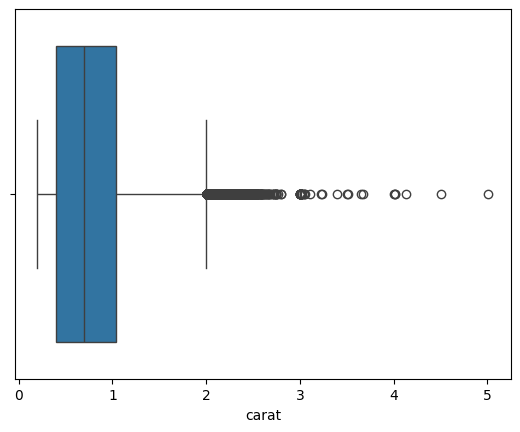

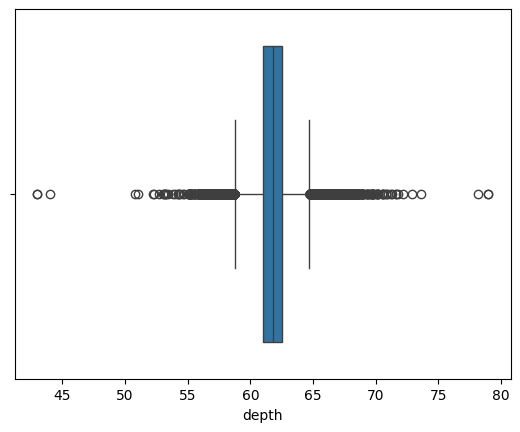

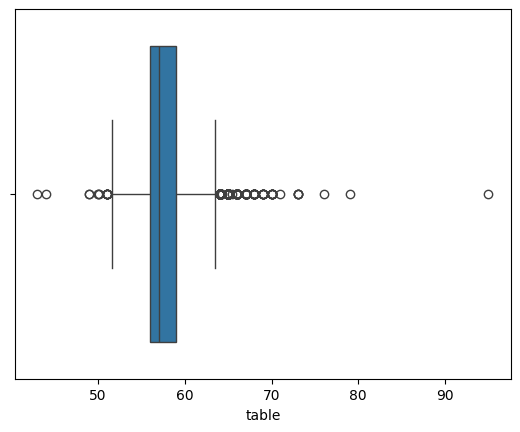

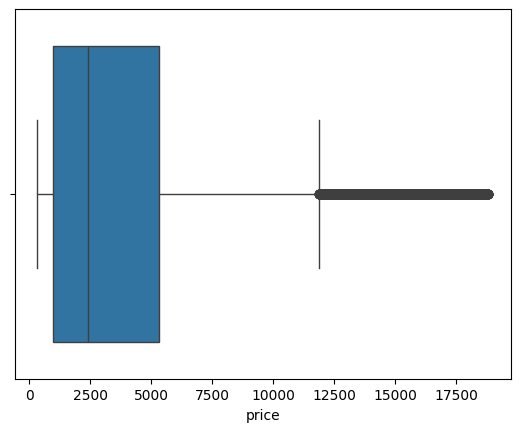

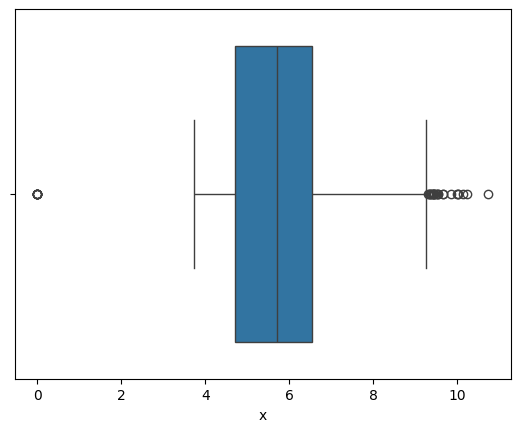

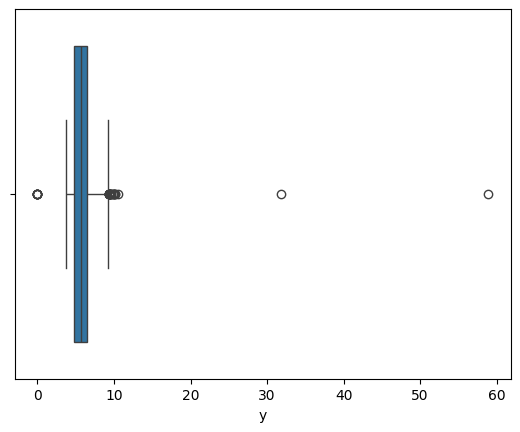

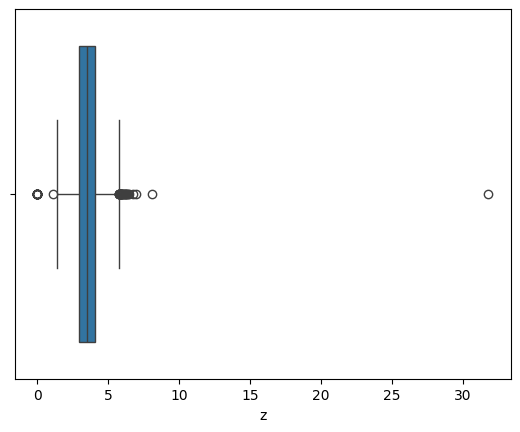

In [175]:
# outliers
for col in df.select_dtypes(include=['number']).columns:
    plt.figure()
    sns.boxplot(data=df, x=df[col])#, #hue='cut')

### Test d'ANOVA

In [173]:
from scipy.stats import f_oneway

# Fonction pour le test
def anova_test(df, var, target='cut', alpha = 0.05):
    # constitution des groupes
    groups = [df[df[target] == cat][var].dropna() for cat in df[target].unique()]

    stat, p = f_oneway(*groups)

    if p < alpha:
        return f"H0 rejetée (p = {p:.6f})"
    else:
        return f"H0 non rejetée (p = {p:.6f})"
    
# Test proprement dit
for col in df.select_dtypes(include=['number']).columns:
    print(f"{col:-<10}{anova_test(df, col, alpha= 0.05)}")

carat-----H0 rejetée (p = 0.000000)
depth-----H0 rejetée (p = 0.000000)
table-----H0 rejetée (p = 0.000000)
price-----H0 rejetée (p = 0.000000)
x---------H0 rejetée (p = 0.000000)
y---------H0 rejetée (p = 0.000000)
z---------H0 rejetée (p = 0.000000)


### Test de Chi2

In [174]:
from scipy.stats import chi2_contingency

# fonction pour le test
def chi2_test(df, var, target='cut', alpha=0.05):
    # tableau de contingence
    contengency = pd.crosstab(df[var], df[target])

    stat, p, dof, expected = chi2_contingency(contengency)

    if p < alpha:
        return f"H0 rejetée (p = {p:.4f})"
    else:
        return f"H0 non rejetée (p = {p:.4f})"

# test proprement dit
for col in df.select_dtypes('category').drop('cut', axis=1).columns:
    print(f"{col:-<10}{chi2_test(df, col)}")

color-----H0 rejetée (p = 0.0000)
clarity---H0 rejetée (p = 0.0000)
